# Re-run of old models

In [1]:
import numpy as np
import pandas as pd 

import matplotlib.pyplot as plt
from matplotlib.patches import Patch

import statsmodels.api as sm

from pathlib import Path

In [2]:
from statsmodels import __version__
__version__

'0.10.1'

In [3]:
# Set up environment
pd.plotting.register_matplotlib_converters()
np.random.seed(42)

In [4]:
path_data = Path(".").absolute().parent / "data"
path_xl = path_data / "ESI_GDP.xlsx"

In [5]:
path_output = Path(".").absolute().parent / "output" / pd.Timestamp.utcnow().strftime("%Y-%m-%d")
path_output.mkdir(exist_ok=True, parents=True)

# Load data

In [6]:
df = pd.read_excel(path_xl)
df.index = df.index.to_series().apply(lambda x: pd.datetime.strptime(x, '%YM%m'))
df.dropna().head()

,GGDP,GESI,GESISA,GGDPSA
2006-05-01,110.800000,106.863298,106.816640,109.458524
2006-06-01,109.258365,106.396667,106.327908,109.290571
2006-07-01,109.859167,104.883275,104.541073,109.045494
2006-08-01,108.508595,101.666480,101.486939,109.335025
2006-09-01,107.968031,99.242416,101.525884,107.570909


In [7]:
ggdp = df["GGDP"]
gesi = df["GESI"]

# Seasonal adjustment (via X13-ARIMA-SEATS)

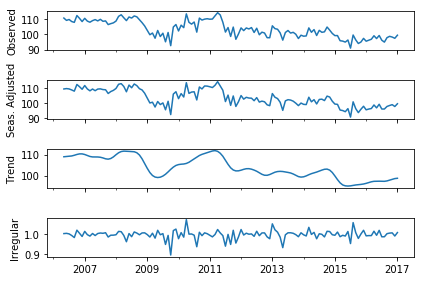

In [8]:
x13_gdp = sm.tsa.x13_arima_analysis(ggdp.dropna())
gdp_sa = x13_gdp.seasadj
x13_gdp.plot();

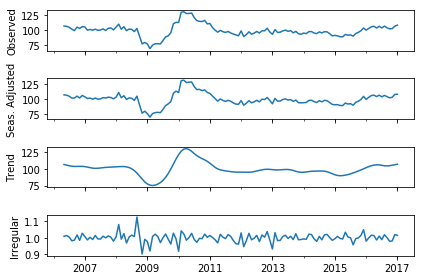

In [9]:
x13_esi = sm.tsa.x13_arima_analysis(gesi.dropna())
esi_sa = x13_esi.seasadj
x13_esi.plot();

# Modelling

## Prepare data

In [10]:
e4 = esi_sa.tshift(4)
e4.head()

2006-09-01    106.942781
2006-10-01    106.416458
2006-11-01    104.651012
2006-12-01    101.612297
2007-01-01    101.684418
Freq: MS, Name: seasadj, dtype: float64

In [11]:
data = pd.concat(
    [gdp_sa.rename("gdp_sa"), esi_sa.rename("esi_sa"), e4.rename("esi_sa_4")], axis="columns"
).dropna(axis="rows")
data['c'] = 1
data['t'] = range(len(data))
pd.concat([data.head(), data.tail()])

,gdp_sa,esi_sa,esi_sa_4,c,t
2006-09-01,107.818316,101.684418,106.942781,1,0
2006-10-01,112.205728,104.856532,106.416458,1,1
2006-11-01,110.749865,101.681628,104.651012,1,2
2006-12-01,109.066078,106.019716,101.612297,1,3
2007-01-01,111.526153,103.606956,101.684418,1,4
2016-09-01,97.738588,104.005035,104.127821,1,120
2016-10-01,98.381886,102.029245,106.423659,1,121
2016-11-01,98.929566,102.895920,103.613860,1,122
2016-12-01,97.712345,107.735059,106.077786,1,123
2017-01-01,99.527172,107.938334,104.005035,1,124


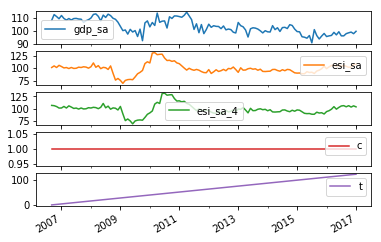

In [12]:
data.plot.line(subplots=True);

In [13]:
actuals = data["gdp_sa"]

## Baseline (Trend + Constant)

In [14]:
mst = sm.tsa.MarkovRegression(
    endog=actuals, k_regimes=2, exog=data[['t']], 
).fit(search_reps=200, em_iter=20, disp=True)


coef_mst = pd.DataFrame({
    'value': mst.params,
    'std': pd.Series(np.sqrt(np.diag(mst.cov_params())), mst.params.index),
    'z': mst.tvalues
})

pred_mst = mst.predict()
res_mst = pd.DataFrame({
    'actual': actuals,
    'pred': pred_mst,
    'resid': actuals - pred_mst,
    'prob_raw': pd.Series(mst.predicted_marginal_probabilities[0], index=data.index),
    'prob_filtered': mst.filtered_marginal_probabilities[0],
    'prob_smoothed': mst.smoothed_marginal_probabilities[0],
})

durbin_watson = np.round(sm.stats.stattools.durbin_watson(res_mst.resid), 3)

res_mst.head()

Optimization terminated successfully.
         Current function value: 2.559849
         Iterations: 24
         Function evaluations: 30
         Gradient evaluations: 30


,actual,pred,resid,prob_raw,prob_filtered,prob_smoothed
2006-09-01,107.818316,109.312423,-1.494107,0.622615,0.458223,0.018278
2006-10-01,112.205728,109.410109,2.795620,0.467209,0.023956,0.000569
2006-11-01,110.749865,109.417576,1.332289,0.056680,0.004179,0.000109
2006-12-01,109.066078,109.422213,-0.356135,0.037984,0.008114,0.000183
2007-01-01,111.526153,109.428003,2.098149,0.041704,0.001642,0.000044


### Plot

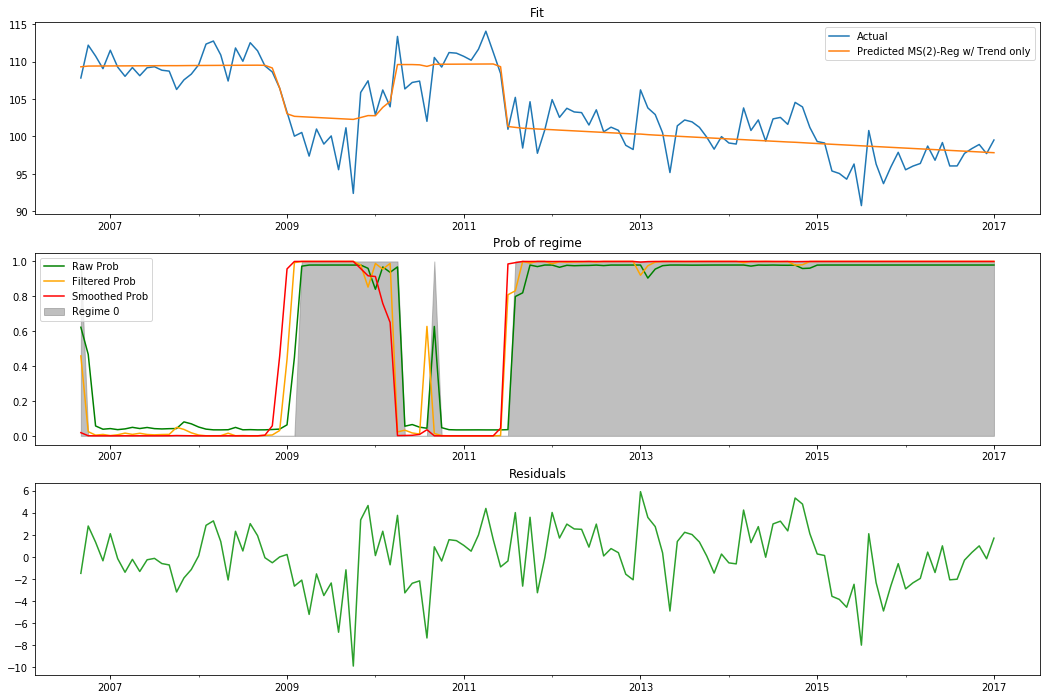

In [15]:
fig, ax = plt.subplots(3, 1, figsize=(18, 12))

ax[0].set_title("Fit")
res_mst.actual.plot.line(ax=ax[0], color="C0", label="Actual")
res_mst.pred.plot.line(ax=ax[0], color="C1", label="Predicted MS(2)-Reg w/ Trend only")
ax[0].legend()

ax[1].set_title("Prob of regime")
res_mst.prob_raw.plot.line(ax=ax[1], color="green", label="Raw Prob")
res_mst.prob_filtered.plot.line(ax=ax[1], color="orange", label="Filtered Prob")
res_mst.prob_smoothed.plot.line(ax=ax[1], color="red", label="Smoothed Prob")
ax[1].fill_between(
    data.index,
    0,
    (res_mst.prob_raw > 0.5).astype(int),
    color="grey",
    alpha=0.5,
    label="Regime 0",
)
ax[1].legend()

ax[2].set_title("Residuals")
res_mst.resid.plot.line(ax=ax[2], color="C2")

fig;

## MS Regression without lag

In [16]:
out_m0 = path_output / "no_lag"
out_m0.mkdir(exist_ok=True, parents=True)

In [17]:
m0 = sm.tsa.MarkovRegression(
    endog=actuals, k_regimes=2, exog=data[['t', 'esi_sa']], 
).fit(search_reps=200, em_iter=20, disp=True)


coef_m0 = pd.DataFrame({
    'value': m0.params,
    'std': pd.Series(np.sqrt(np.diag(m0.cov_params())), m0.params.index),
    'z': m0.tvalues
})

pred_m0 = m0.predict()
res_m0 = pd.DataFrame({
    'actual': actuals,
    'pred': pred_m0,
    'resid': actuals - pred_m0,
    'prob_raw': pd.Series(m0.predicted_marginal_probabilities[0], index=data.index),
    'prob_filtered': m0.filtered_marginal_probabilities[0],
    'prob_smoothed': m0.smoothed_marginal_probabilities[0],
})

durbin_watson_m0 = np.round(sm.stats.stattools.durbin_watson(res_m0.resid), 3)

res_m0.head()

Optimization terminated successfully.
         Current function value: 2.488224
         Iterations: 48
         Function evaluations: 54
         Gradient evaluations: 54


,actual,pred,resid,prob_raw,prob_filtered,prob_smoothed
2006-09-01,107.818316,109.128327,-1.310011,0.337614,0.339181,0.951185
2006-10-01,112.205728,109.503208,2.702520,0.339090,0.733244,0.988804
2006-11-01,110.749865,109.309539,1.440326,0.710232,0.904748,0.995732
2006-12-01,109.066078,109.664668,-0.598590,0.871761,0.907829,0.997076
2007-01-01,111.526153,109.514492,2.011661,0.874663,0.973684,0.998811


### Export to Excel

In [18]:
writer = pd.ExcelWriter(out_m0 / "results.xlsx")
with writer:
    res_m0.to_excel(writer, sheet_name='Results')
    coef_m0.to_excel(writer, sheet_name='Coefficients')

### Plot

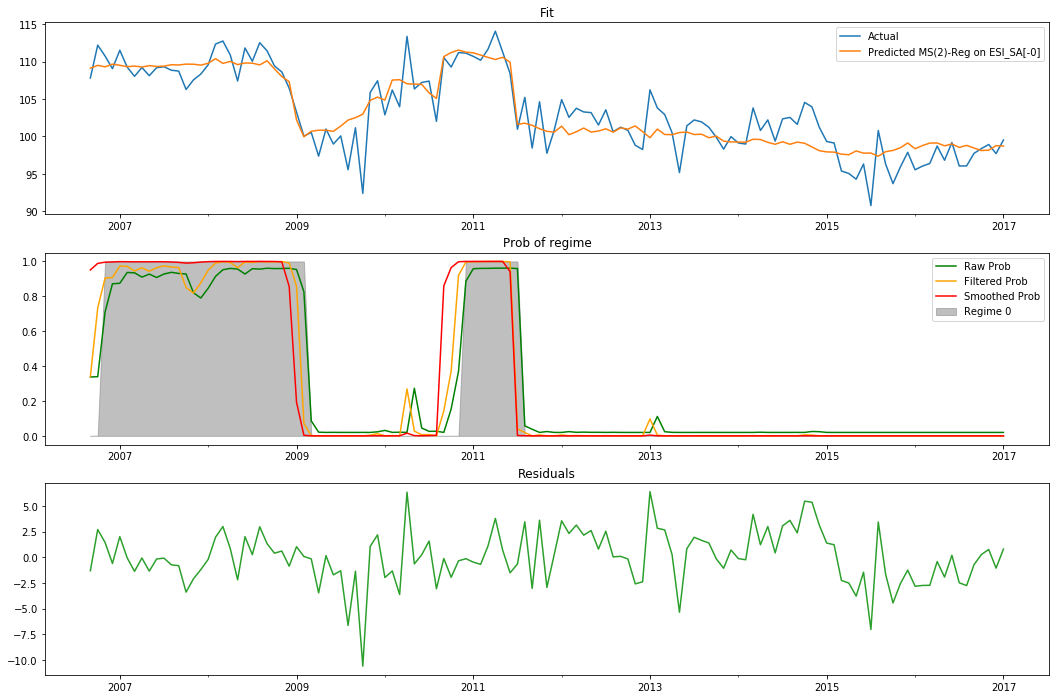

In [19]:
fig, ax = plt.subplots(3, 1, figsize=(18, 12))

ax[0].set_title("Fit")
res_m0.actual.plot.line(ax=ax[0], color="C0", label="Actual")
res_m0.pred.plot.line(ax=ax[0], color="C1", label="Predicted MS(2)-Reg on ESI_SA[-0]")
ax[0].legend()

ax[1].set_title("Prob of regime")
res_m0.prob_raw.plot.line(ax=ax[1], color="green", label="Raw Prob")
res_m0.prob_filtered.plot.line(ax=ax[1], color="orange", label="Filtered Prob")
res_m0.prob_smoothed.plot.line(ax=ax[1], color="red", label="Smoothed Prob")
ax[1].fill_between(
    data.index,
    0,
    (res_m0.prob_raw > 0.5).astype(int),
    color="grey",
    alpha=0.5,
    label="Regime 0",
)
ax[1].legend()

ax[2].set_title("Residuals")
res_m0.resid.plot.line(ax=ax[2], color="C2")

fig.savefig(out_m0 / "model_fits.png")
fig;

### Model Summary

In [20]:
summary_m0 = m0.summary()

# Add variable information
tbl_variables = sm.iolib.table.SimpleTable(
    [
        ['const', 'Intercept term'],
        ['x1', 'Linear trend (t)'],
        ['x2', 'GESI_SA[-0] (seasonally adjusted by X13)']
    ],
    headers=["Variable", "Name"], title='Variable information'
)
summary_m0.tables.insert(1, tbl_variables)

# Add regime information
tbl_regimes = sm.iolib.table.SimpleTable(
    [[i, np.round(m0.expected_durations[i], 3)] for i in range(2)],
    headers=["Regime", "Expected Duration"], title='Other regime information'
)
summary_m0.tables.append(tbl_regimes)

# Other 
tbl_other_stats = sm.iolib.table.SimpleTable(
    [
        ['Durbin-Watson', durbin_watson_m0],
    ],
    headers=["Statistic", "Value"], title='Other statistics'
)
summary_m0.tables.append(tbl_other_stats)

# Get rid of warning text at end
summary_m0.add_extra_txt([])

# Write to file
with (out_m0 / "summary.txt").open("w") as f:
    f.write(summary_m0.as_text())

summary_m0

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Markov Switching Model Results                        
==============================================================================
Dep. Variable:                 gdp_sa   No. Observations:                  125
Model:               MarkovRegression   Log Likelihood                -311.028
Date:                Wed, 05 Feb 2020   AIC                            640.056
Time:                        14:53:06   BIC                            665.511
Sample:                    09-01-2006   HQIC                           650.397
                         - 01-01-2017                                         
Covariance Type:               approx                                         
               Variable information              
=================================================
Variable                   Name                  
-------------------------------------------------
   const                           Intercept term
      x1                         Linear trend (t)
      x2 GESI_SA[-0] (seasonally adjusted by X13)
                             Regime 0 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        101.6591      6.532     15.564      0.000      88.858     114.461
x1             0.0256      0.024      1.079      0.281      -0.021       0.072
x2             0.0749      0.065      1.160      0.246      -0.052       0.201
                             Regime 1 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         92.3561      2.608     35.408      0.000      87.244      97.468
x1            -0.0683      0.010     -6.624      0.000      -0.088      -0.048
x2             0.1374      0.025      5.402      0.000       0.088       0.187
                           Non-switching parameters                           
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         6.9062      0.891      7.752      0.000       5.160       8.652
                         Regime transition parameters                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
p[0->0]        0.9615      0.031     31.271      0.000       0.901       1.022
p[1->0]        0.0196      0.014      1.369      0.171      -0.008       0.048
Other regime information
========================
Regime Expected Duration
------------------------
     0            25.956
     1            50.924
  Other statistics 
===================
  Statistic   Value
-------------------
Durbin-Watson 1.565
-------------------


"""

### Residual Diagnostics

In [21]:
durbin_watson

1.404

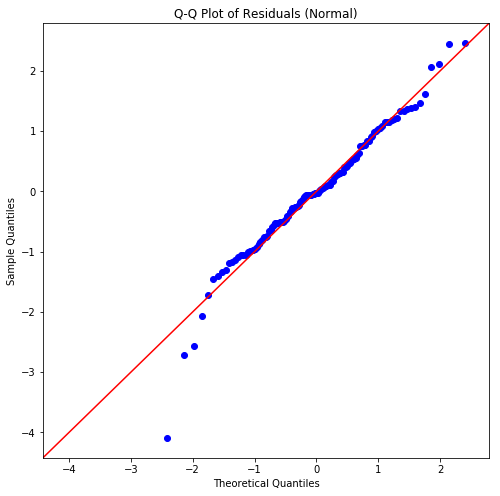

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.set_title("Q-Q Plot of Residuals (Normal)")
sm.graphics.qqplot(res_m0.resid / np.std(res_m0.resid), line="45", ax=ax)
fig.savefig(out_m0 / "resid_qq.png")

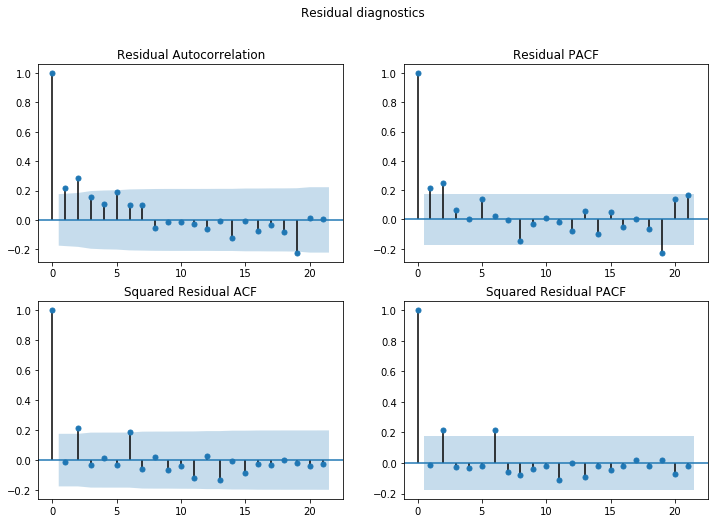

In [23]:
fig, ax = plt.subplots(2, 2, figsize=(12, 8))
sm.tsa.graphics.plot_acf(res_m0.resid, ax=ax[0,0], title='Residual Autocorrelation')
sm.tsa.graphics.plot_pacf(res_m0.resid, ax=ax[0,1], title='Residual PACF')
sm.tsa.graphics.plot_acf(res_m0.resid**2, ax=ax[1,0], title='Squared Residual ACF')
sm.tsa.graphics.plot_pacf(res_m0.resid**2, ax=ax[1,1], title='Squared Residual PACF')
fig.suptitle("Residual diagnostics")

fig.savefig(out_m0 / "resid_acf.png")
fig;

## MS Regression with lag

In [24]:
out_mlr = path_output / "lag_4"
out_mlr.mkdir(exist_ok=True, parents=True)

In [25]:
actuals = data["gdp_sa"]

mlr =sm.tsa.MarkovRegression(
    endog=actuals, k_regimes=2, exog=data[['t', "esi_sa_4"]], 
).fit(search_reps=200, em_iter=20, disp=True)

coef = pd.DataFrame({
    'value': mlr.params,
    'std': pd.Series(np.sqrt(np.diag(mlr.cov_params())), mlr.params.index),
    'z': mlr.tvalues
})

pred_mlr = mlr.predict()
res = pd.DataFrame({
    'actual': actuals,
    'pred': pred_mlr,
    'resid': actuals - pred_mlr,
    'prob_raw': pd.Series(mlr.predicted_marginal_probabilities[0], index=data.index),
    'prob_filtered': mlr.filtered_marginal_probabilities[0],
    'prob_smoothed': mlr.smoothed_marginal_probabilities[0],
})

durbin_watson = np.round(sm.stats.stattools.durbin_watson(res.resid), 3)

res.head()

Optimization terminated successfully.
         Current function value: 2.387389
         Iterations: 50
         Function evaluations: 56
         Gradient evaluations: 56


,actual,pred,resid,prob_raw,prob_filtered,prob_smoothed
2006-09-01,107.818316,110.161706,-2.343390,0.419318,0.932798,0.954255
2006-10-01,112.205728,110.313015,1.892713,0.805896,0.743071,0.877018
2006-11-01,110.749865,110.064797,0.685068,0.663059,0.718104,0.871258
2006-12-01,109.066078,109.661214,-0.595136,0.644262,0.756799,0.874582
2007-01-01,111.526153,109.605710,1.920443,0.673394,0.565304,0.860340


### Export to Excel

In [26]:
writer = pd.ExcelWriter(out_mlr / "results.xlsx")
with writer:
    res.to_excel(writer, sheet_name='Results')
    coef.to_excel(writer, sheet_name='Coefficients')

### Plot

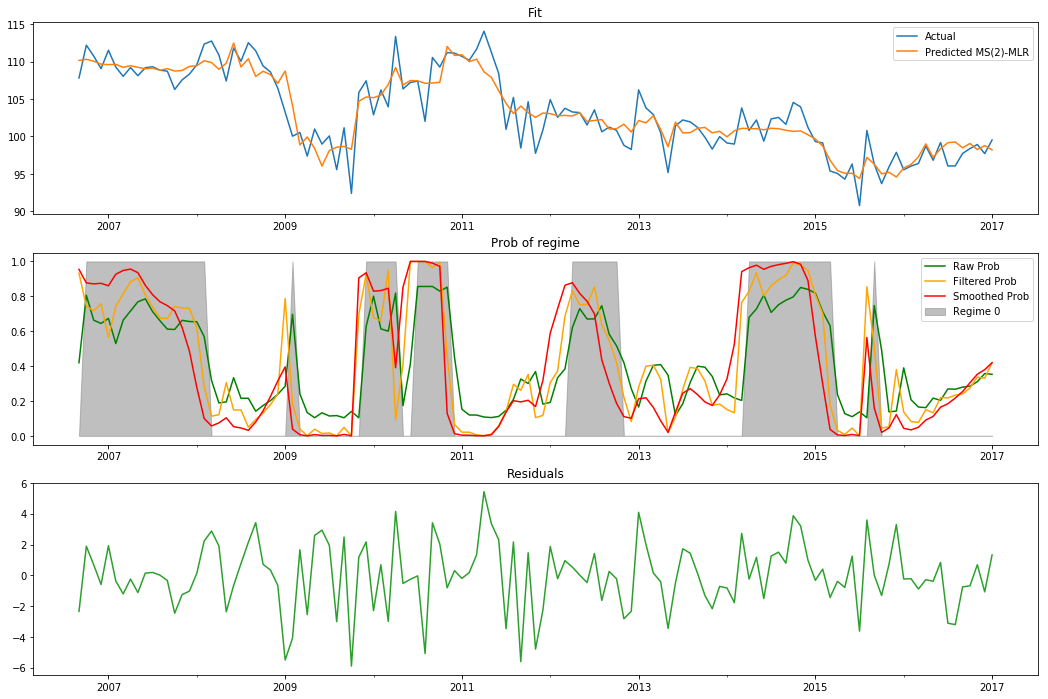

In [27]:
fig, ax = plt.subplots(3, 1, figsize=(18, 12))

ax[0].set_title("Fit")
res.actual.plot.line(ax=ax[0], color="C0", label="Actual")
res.pred.plot.line(ax=ax[0], color="C1", label="Predicted MS(2)-MLR")
ax[0].legend()

ax[1].set_title("Prob of regime")
res.prob_raw.plot.line(ax=ax[1], color="green", label="Raw Prob")
res.prob_filtered.plot.line(ax=ax[1], color="orange", label="Filtered Prob")
res.prob_smoothed.plot.line(ax=ax[1], color="red", label="Smoothed Prob")
ax[1].fill_between(
    data.index,
    0,
    (res.prob_raw > 0.5).astype(int),
    color="grey",
    alpha=0.5,
    label="Regime 0",
)
ax[1].legend()

ax[2].set_title("Residuals")
res.resid.plot.line(ax=ax[2], color="C2")

fig.savefig(out_mlr / "model_fits.png")
fig;

### Model summary

Variables in the model:

- `const` is the intercept
- `x1` is the linear trend
- `x2` is the esi_sa\[-4\] variable

In [28]:
summary = mlr.summary()

# Add variable information
tbl_variables = sm.iolib.table.SimpleTable(
    [
        ['const', 'Intercept term'],
        ['x1', 'Linear trend (t)'],
        ['x2', 'GESI_SA[-4] (seasonally adjusted by X13)']
    ],
    headers=["Variable", "Name"], title='Variable information'
)
summary.tables.insert(1, tbl_variables)

# Add regime information
tbl_regimes = sm.iolib.table.SimpleTable(
    [[i, np.round(mlr.expected_durations[i], 3)] for i in range(2)],
    headers=["Regime", "Expected Duration"], title='Other regime information'
)
summary.tables.append(tbl_regimes)

# Other 
tbl_other_stats = sm.iolib.table.SimpleTable(
    [
        ['Durbin-Watson', durbin_watson],
    ],
    headers=["Statistic", "Value"], title='Other statistics'
)
summary.tables.append(tbl_other_stats)

# Get rid of warning text at end
summary.add_extra_txt([])

# Write to file
with (out_mlr / "summary.txt").open("w") as f:
    f.write(summary.as_text())

summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Markov Switching Model Results                        
==============================================================================
Dep. Variable:                 gdp_sa   No. Observations:                  125
Model:               MarkovRegression   Log Likelihood                -298.424
Date:                Wed, 05 Feb 2020   AIC                            614.847
Time:                        14:53:11   BIC                            640.302
Sample:                    09-01-2006   HQIC                           625.188
                         - 01-01-2017                                         
Covariance Type:               approx                                         
               Variable information              
=================================================
Variable                   Name                  
-------------------------------------------------
   const                           Intercept term
      x1                         Linear trend (t)
      x2 GESI_SA[-4] (seasonally adjusted by X13)
                             Regime 0 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        103.5158      3.889     26.615      0.000      95.893     111.139
x1            -0.0879      0.016     -5.578      0.000      -0.119      -0.057
x2             0.0605      0.036      1.682      0.093      -0.010       0.131
                             Regime 1 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         74.3699      3.238     22.966      0.000      68.023      80.717
x1            -0.1212      0.011    -10.669      0.000      -0.143      -0.099
x2             0.3688      0.035     10.489      0.000       0.300       0.438
                           Non-switching parameters                           
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         5.2727      0.936      5.634      0.000       3.438       7.107
                         Regime transition parameters                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
p[0->0]        0.8565      0.090      9.534      0.000       0.680       1.033
p[1->0]        0.1036      0.087      1.194      0.233      -0.067       0.274
Other regime information
========================
Regime Expected Duration
------------------------
     0             6.968
     1              9.65
  Other statistics 
===================
  Statistic   Value
-------------------
Durbin-Watson 2.029
-------------------


"""

### Residual Diagnostics

In [29]:
durbin_watson

2.029

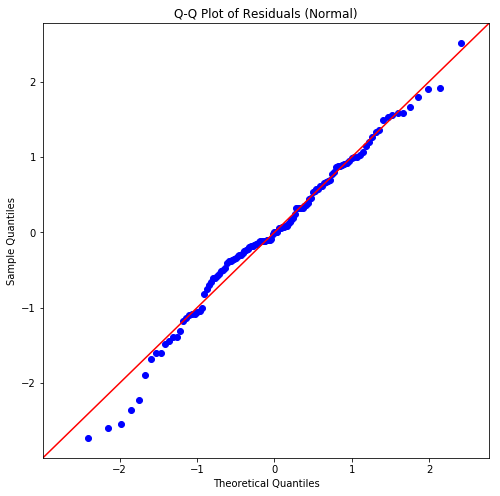

In [30]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.set_title("Q-Q Plot of Residuals (Normal)")
sm.graphics.qqplot(res.resid / np.std(res.resid), line="45", ax=ax)
fig.savefig(out_mlr / "resid_qq.png")

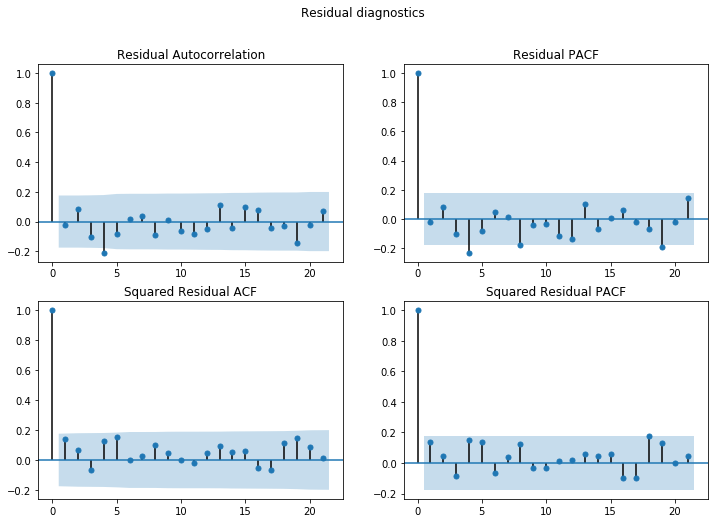

In [31]:
fig, ax = plt.subplots(2, 2, figsize=(12, 8))
sm.tsa.graphics.plot_acf(res.resid, ax=ax[0,0], title='Residual Autocorrelation')
sm.tsa.graphics.plot_pacf(res.resid, ax=ax[0,1], title='Residual PACF')
sm.tsa.graphics.plot_acf(res.resid**2, ax=ax[1,0], title='Squared Residual ACF')
sm.tsa.graphics.plot_pacf(res.resid**2, ax=ax[1,1], title='Squared Residual PACF')
fig.suptitle("Residual diagnostics")

fig.savefig(out_mlr / "resid_acf.png")
fig;